In [1]:
from IPython.display import Image

## basics

- https://github.com/huggingface/trl/tree/main
- https://github.com/huggingface/trl/tree/main/examples/notebooks

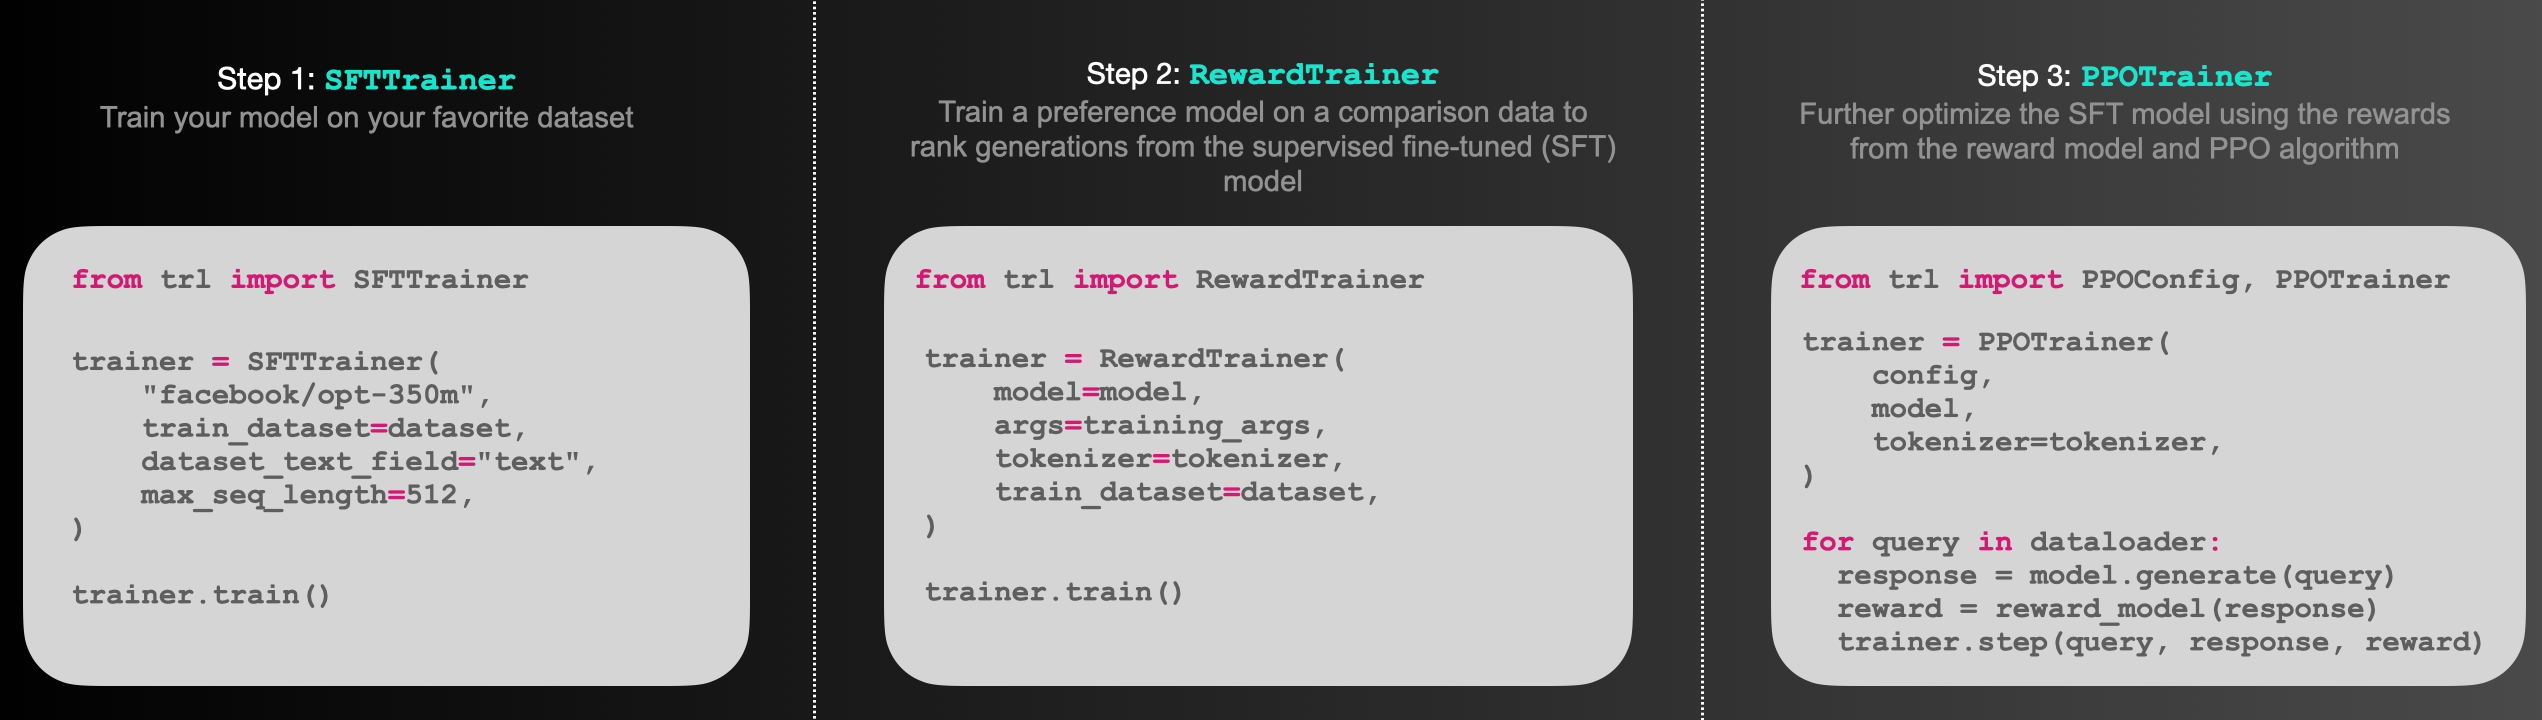

In [22]:
Image('../imgs/trl_steps.png')

### value head

- `AutoModelForCausalLMWithValueHead`
    - `foward()`
        - `return (lm_logits, loss, value)`
            - `lm_logits.shape`: (bs, seq_len, vocab_size)
            - `value.shape`: (bs, seq_len)
- `AutoModelForCausalLMWithValueHead` & `AutoModelForSeq2SeqLMWithValueHead`: 
    - A transformer model with an additional scalar output for each token which can be used as a value function in reinforcement learning.

### ppo_trainer.step()

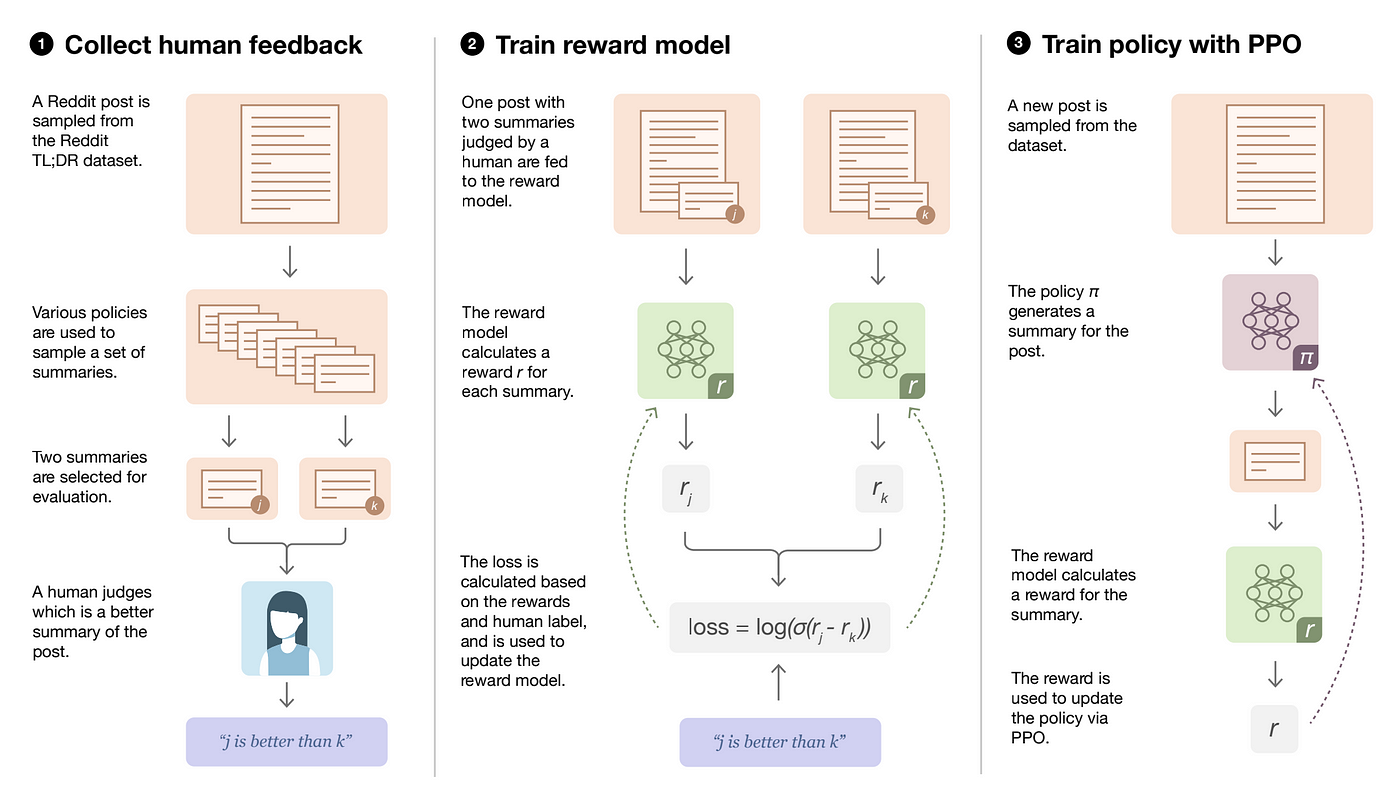

In [18]:
Image('../imgs/rm_ppo.png')

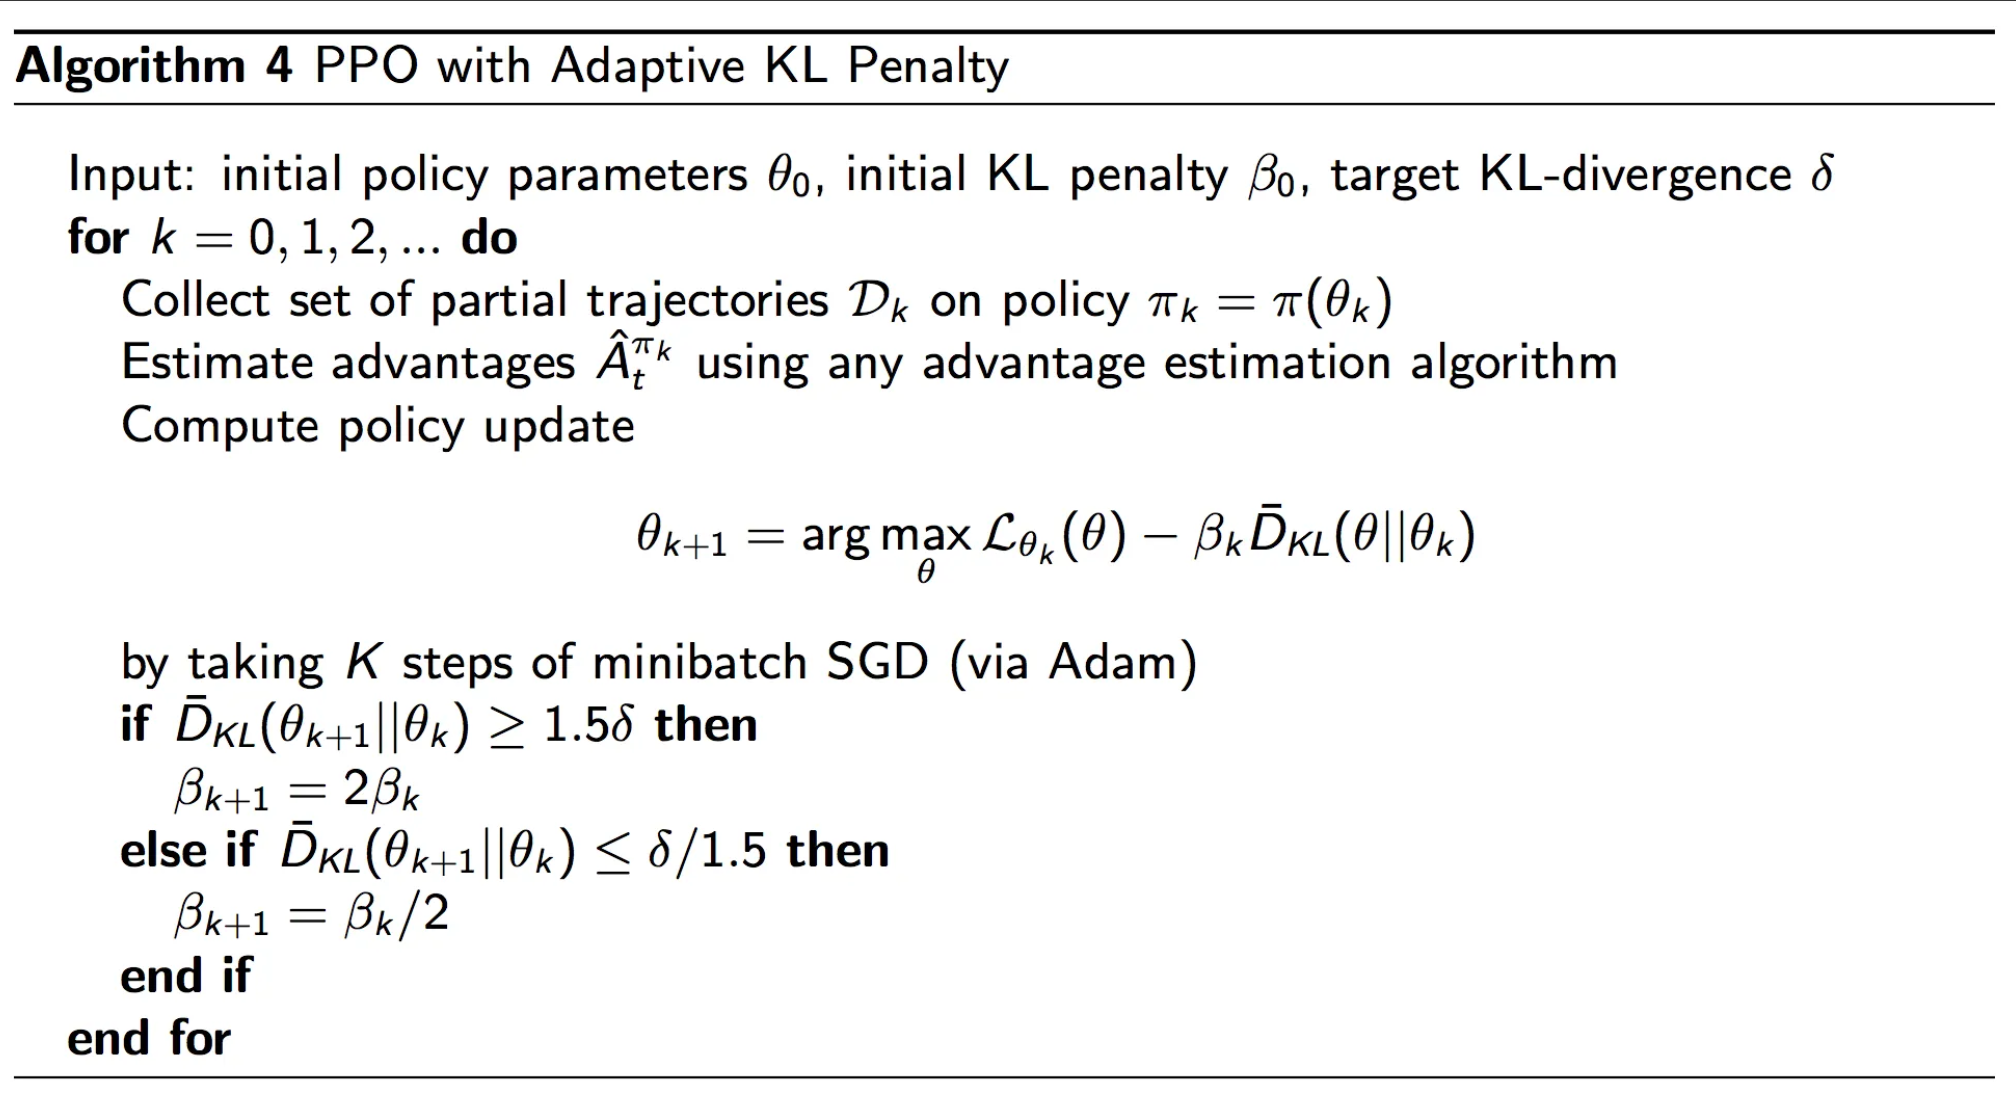

In [21]:
Image('../imgs/ppo_algo.png', width=600)

## examples 与示例代码（sft_trainer on llama2）

```
pip install trl
git clone https://github.com/lvwerra/trl
python trl/examples/scripts/sft_trainer.py \
    --model_name meta-llama/Llama-2-7b-hf \
    --dataset_name timdettmers/openassistant-guanaco \
    --load_in_4bit \
    --use_peft \
    --batch_size 4 \
    --gradient_accumulation_steps 2
```

- 默认情况下
    - optimize：AdamW
    - lr scheduler：linear
        - warm up ratio：0

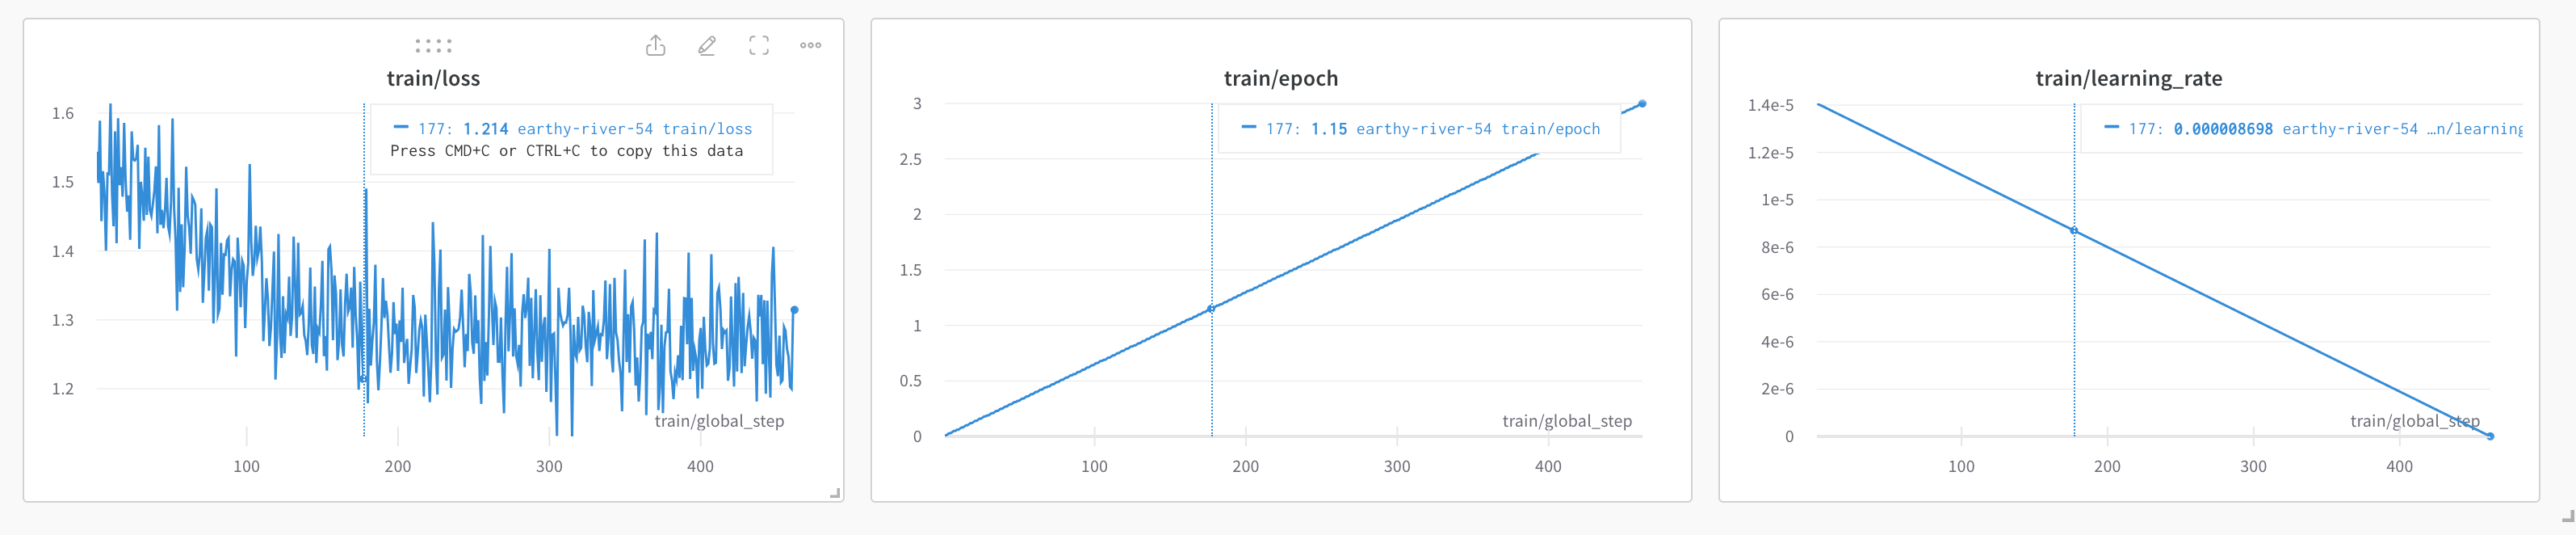

In [20]:
Image('../imgs/trl-sft.png')

## quick start

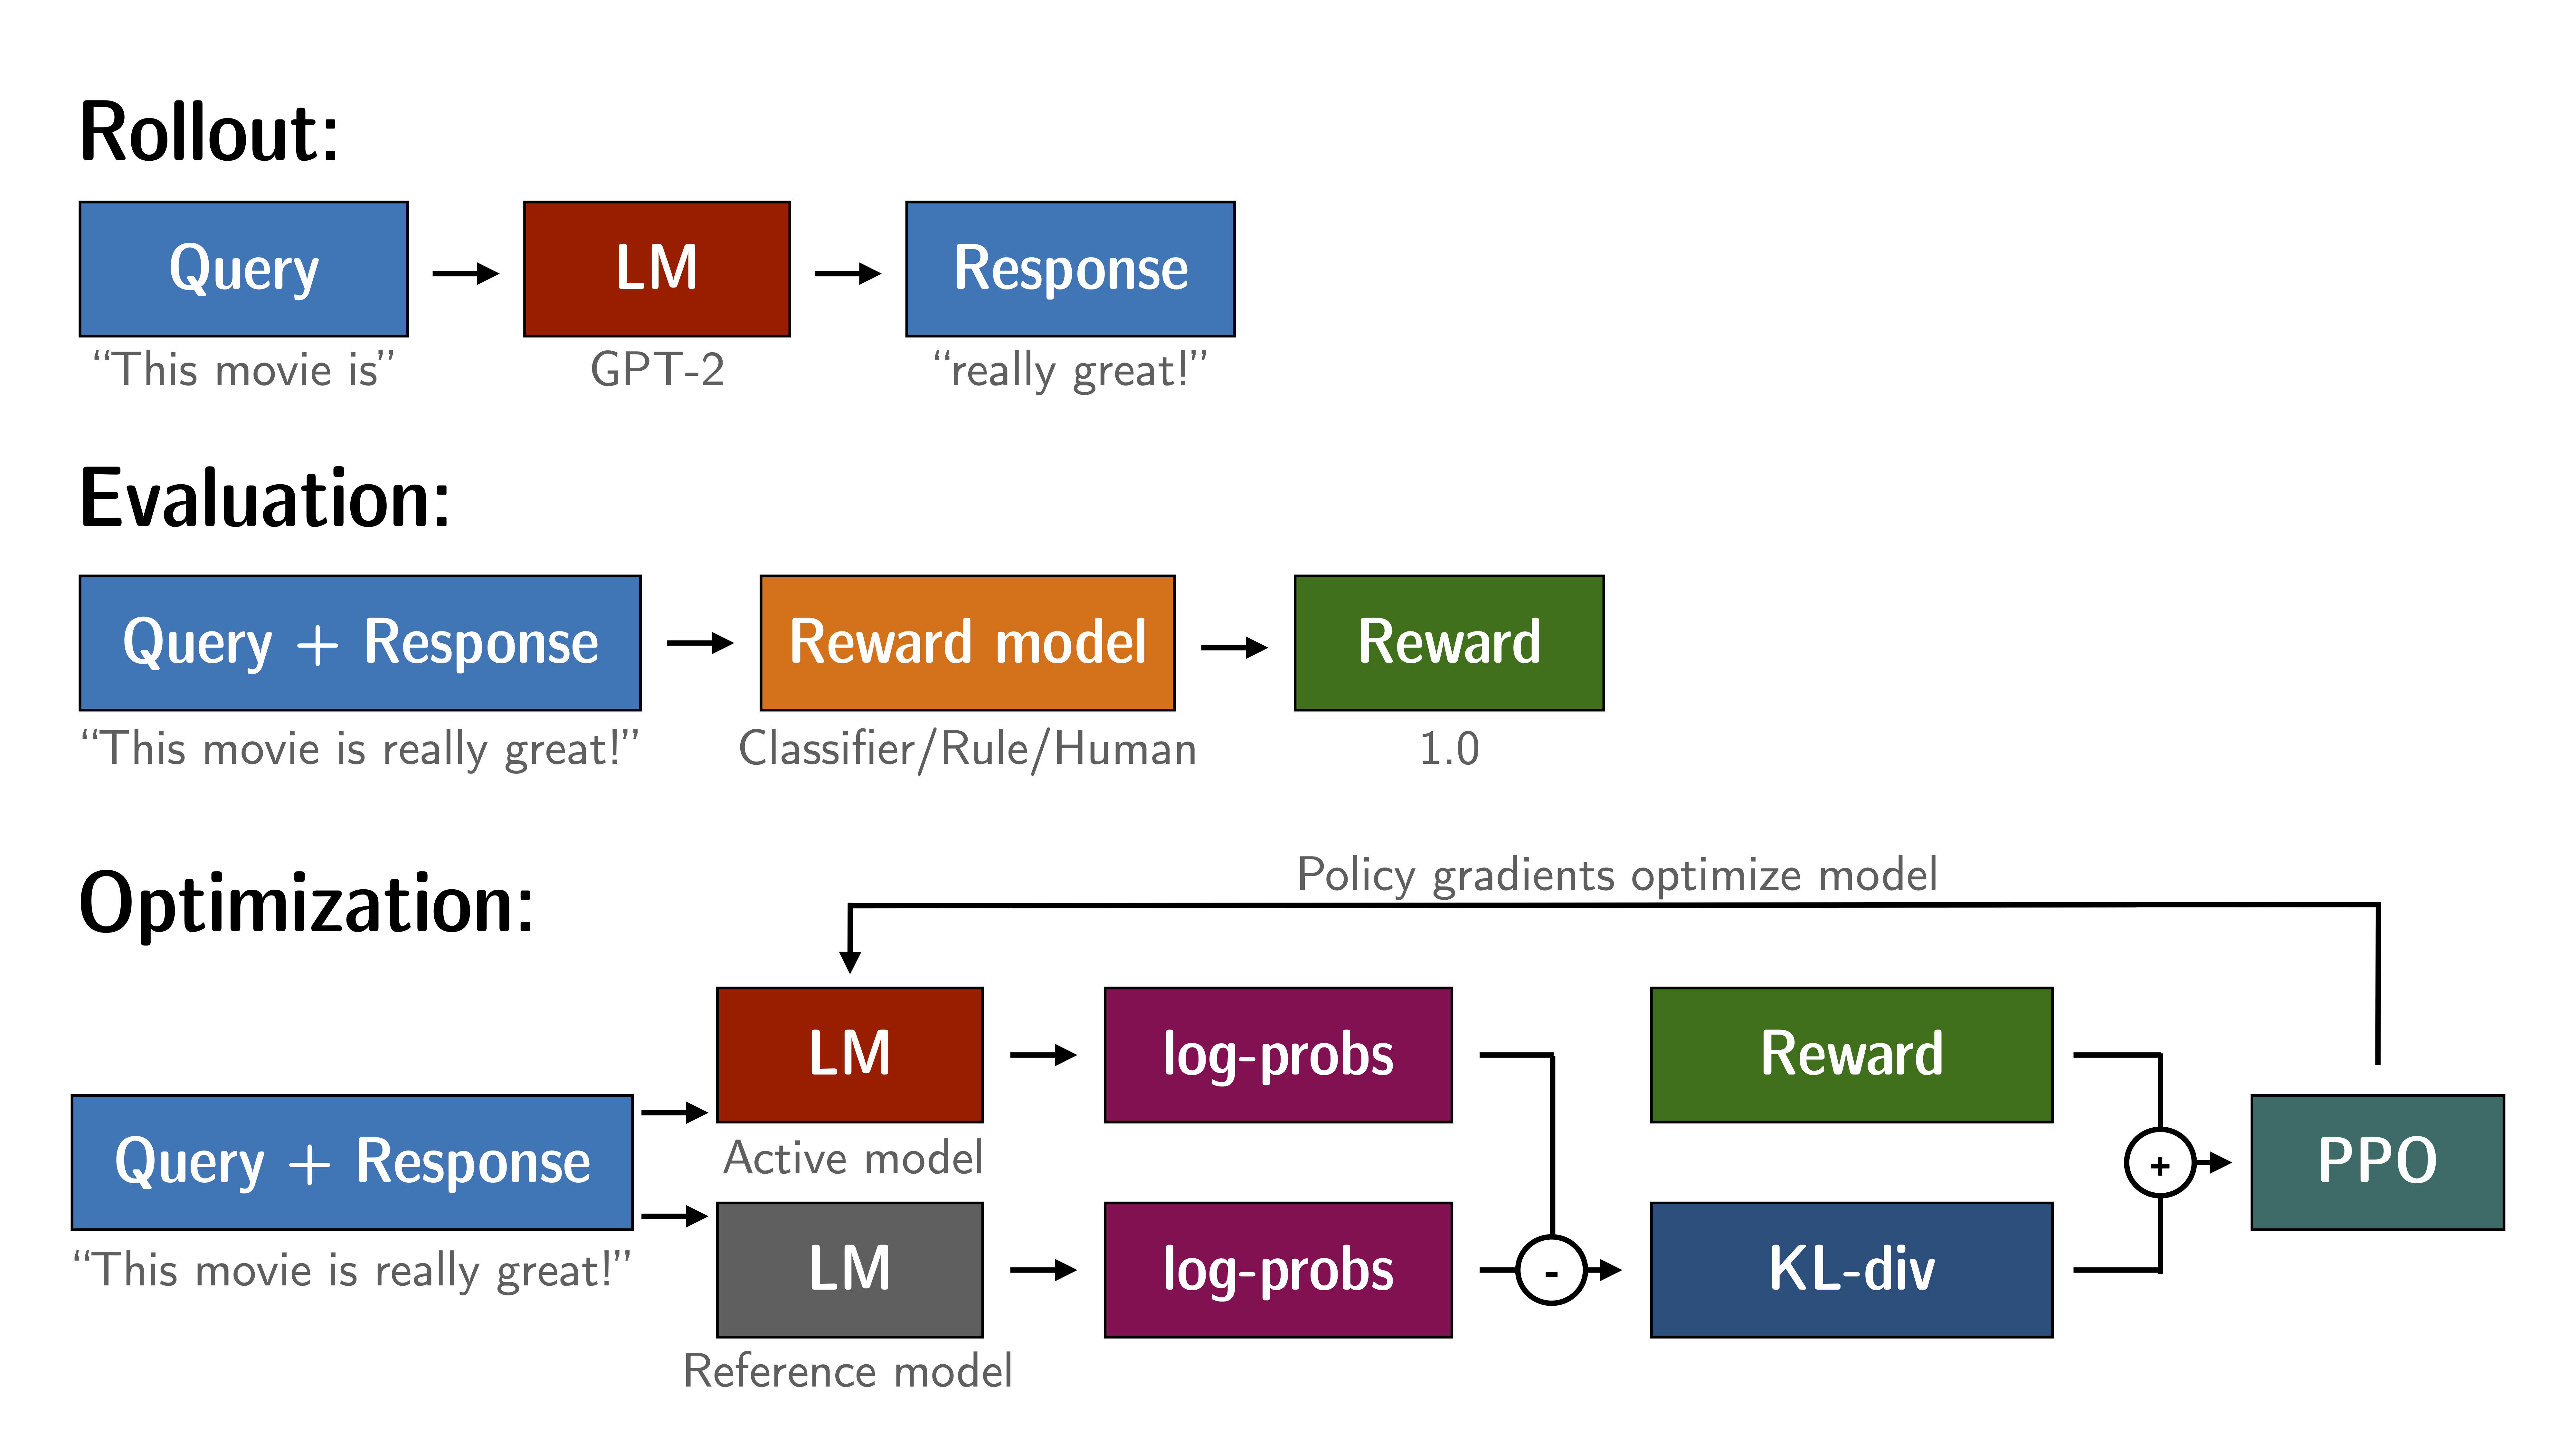

In [25]:
Image('../imgs/trl_overview.png', width=500)

- model: active model
- ref model: reference model
- reward model: RM

In [2]:
import torch
import numpy as np
import random
from transformers import GPT2Tokenizer
from transformers import AutoModelForCausalLM
from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(42)

In [4]:
model = AutoModelForCausalLMWithValueHead.from_pretrained("gpt2")
model_ref = AutoModelForCausalLMWithValueHead.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [26]:
tokenizer

GPT2Tokenizer(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True)

In [28]:
model.pretrained_model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [29]:
model.v_head

ValueHead(
  (dropout): Dropout(p=0.1, inplace=False)
  (summary): Linear(in_features=768, out_features=1, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [5]:
# 2. initialize trainer
ppo_config = {"batch_size": 1}
config = PPOConfig(**ppo_config)
ppo_trainer = PPOTrainer(config, model, model_ref, tokenizer)

/home/whaow/anaconda3/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:235: UserWarning: No dataset is provided. Make sure to set config.batch_size to the correct value before training.
  warnings.warn(


In [6]:
model.pretrained_model.device

device(type='cuda', index=0)

In [31]:
query_txt = "This morning I went to the "
query_tensor = tokenizer.encode(query_txt, return_tensors="pt").to(model.pretrained_model.device)
query_tensor

tensor([[1212, 3329,  314, 1816,  284,  262,  220]], device='cuda:0')

In [32]:
generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 20,
}

In [9]:
response_tensor = ppo_trainer.generate([item for item in query_tensor], return_prompt=True, **generation_kwargs)

In [33]:
response_txt = tokenizer.decode(response_tensor[0])
response_txt

'This morning I went to the vernacular and found myself at a bar, cook, with a wife. Buggas together in'

In [ ]:
# 5. define a reward for response
# (this could be any reward such as human feedback or output from another model)
# got from a reward model
reward = [torch.tensor(1.0, device=model.pretrained_model.device)]

# 6. train model with ppo
train_stats = ppo_trainer.step([query_tensor[0]], [response_tensor[0]], reward)

In [ ]:
train_stats

## from scartch

```
train_stats = ppo_trainer.step([query_tensor[0]], [response_tensor[0]], reward)

    all_logprobs, _, values, masks = self.batched_forward_pass(self.model, queries, responses, model_inputs)
    
    ref_logprobs, _, _, _ = self.batched_forward_pass(self.ref_model, queries, responses, model_inputs)
    
    # kl loss
    rewards, non_score_reward = self.compute_rewards(scores, all_logprobs, ref_logprobs, masks)
    
    for _ in range(self.config.ppo_epochs):
        logprobs, logits, vpreds, _ = self.batched_forward_pass(
                        self.model, batch["queries"], batch["responses"], model_inputs, return_logits=True
                    )
        train_stats = self.train_minibatch(
                        batch["logprobs"],
                        batch["values"],
                        batch["rewards"],
                        logprobs,
                        logits,
                        vpreds,
                        batch["masks"],
                    )
            loss_p, loss_v, train_stats = self.loss(old_logprobs, values, rewards, logits, vpreds, logprobs, mask)
```

In [11]:
input_ids = torch.cat([query_tensor[0], response_tensor[0]])
print(query_tensor[0].shape)
print(response_tensor[0].shape)
print(input_ids.shape)

torch.Size([7])
torch.Size([27])
torch.Size([34])


In [12]:
tokenizer.decode(input_ids)

'This morning I went to the This morning I went to the vernacular and found myself at a bar, cook, with a wife. Buggas together in'

### base model forward

In [34]:
base_model_output = model.pretrained_model(input_ids, output_hidden_states=True)

In [35]:
last_hidden_state = base_model_output.hidden_states[-1]
print(last_hidden_state.shape)
lm_logits = base_model_output.logits
print(lm_logits.shape)
# loss = base_model_output.loss
# print(loss.shape)

torch.Size([34, 768])
torch.Size([34, 50257])


### value head

In [23]:
model.v_head

ValueHead(
  (dropout): Dropout(p=0.1, inplace=False)
  (summary): Linear(in_features=768, out_features=1, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [36]:
print(last_hidden_state.shape)
with torch.no_grad():
    # (34, 768) * (768, 1) => (34, 1)
    value = model.v_head(last_hidden_state).squeeze(-1)
    print(value.shape)

torch.Size([34, 768])
torch.Size([34])


In [37]:
value

tensor([-1.5424,  0.6099, -6.9266, -4.2521, -3.3896, -4.4121, -5.0044, -5.3269,
        -2.5041, -4.6306,  1.5044,  0.0116, -3.7868, -6.1114,  1.0392, -5.9400,
        -6.7026, -4.2099, -6.7242, -5.0096, -7.3120, -7.8070,  0.8301, -5.7430,
        -6.4138, -6.2018, -6.5330, -5.0721, -6.8700, -6.8804, -5.9335, -7.4025,
        -6.4230, -7.0726], device='cuda:0')